In [63]:
%autosave 300
%reload_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

Autosaving every 300 seconds


In [64]:
import os

os.chdir(
    "/mnt/batch/tasks/shared/LS_root/mounts/clusters/copilot-model-run/code/Users/Soutrik.Chowdhury/pytorch_lightning_journey/lightning_basics"
)
print(os.getcwd())

/mnt/batch/tasks/shared/LS_root/mounts/clusters/copilot-model-run/code/Users/Soutrik.Chowdhury/pytorch_lightning_journey/lightning_basics


In [65]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [66]:
import lightning as L
import torch
import torch.nn.functional as F
from intro.shared_utils import (
    TorchMLP,
    dataset_reader,
    dataset_loader,
    compute_accuracy,
)
import torchmetrics
from lightning.pytorch.callbacks import RichProgressBar, RichModelSummary

In [67]:
torch.manual_seed(71)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


**lightning module for model training and validation**

In [6]:
from typing import Any


class LightningMLP(L.LightningModule):

    def __init__(self, model, learning_rate):
        super().__init__()
        self.learning_rate = learning_rate
        self.model = model
        self.criterion = torch.nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        features, true_labels = batch
        logits = self(features)
        loss = self.criterion(logits, true_labels)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        features, true_labels = batch
        logits = self(features)
        loss = self.criterion(logits, true_labels)
        self.log("val_loss", loss, prog_bar=True)

    def test_step(self, batch, batch_idx):
        pass

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(
            self.parameters(), lr=self.learning_rate, momentum=0.9
        )
        return optimizer

In [7]:
train_data, val_data, test_data = dataset_reader()

In [8]:
train_dataloader, val_dataloader, test_dataloader = dataset_loader(
    train_data, val_data, test_data, 10
)

In [9]:
for data, labels in train_dataloader:
    print(data.shape)
    print(len(labels))
    break

for data, labels in val_dataloader:
    print(data.shape)
    print(len(labels))
    break

for data, labels in test_dataloader:
    print(data.shape)
    print(len(labels))
    break

# as we are using basic mlp model flatten() is required

torch.Size([64, 1, 28, 28])
64
torch.Size([64, 1, 28, 28])
64
torch.Size([64, 1, 28, 28])
64


In [10]:
# basic torch model
torch_model = TorchMLP(input_dim=784, hidden_dim=50, output_dim=10).to(device)

In [11]:
# lightning model
lightning_model = LightningMLP(model=torch_model, learning_rate=0.01)

In [12]:
trainer = L.Trainer(
    max_epochs=2,
    accelerator="auto",
    devices="auto",
    deterministic=True,
    enable_progress_bar=True,
    enable_model_summary=True,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [13]:
trainer.fit(
    model=lightning_model,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

2024-07-22 15:21:47.611488: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-22 15:21:47.611537: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-22 15:21:47.612489: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-22 15:21:47.619027: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-22 15:21:48.501606: W tensorflow/compiler/tf2

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.


In [14]:
train_acc = compute_accuracy(lightning_model, train_dataloader, torch.device("cpu"))

In [15]:
val_acc = compute_accuracy(lightning_model, val_dataloader, torch.device("cpu"))

In [16]:
test_acc = compute_accuracy(lightning_model, test_dataloader, torch.device("cpu"))

In [17]:
print(
    f"Train Acc {train_acc*100:.2f}%"
    f" | Val Acc {val_acc*100:.2f}%"
    f" | Test Acc {test_acc*100:.2f}%"
)

Train Acc 85.74% | Val Acc 84.66% | Test Acc 84.15%


**Pytorch lighning model resets its device outside of training loop , so we have to do everything within training function only**

In [19]:
PATH = "./models/"
os.makedirs(PATH, exist_ok=True)
torch.save(torch_model.state_dict(), os.path.join(PATH, "basic_model.pth"))

In [ ]:
# To load model:
# model = PyTorchMLP(num_features=784, num_classes=10)
# model.load_state_dict(torch.load(PATH))
# model.eval()

**Application of torch metrics**

In [90]:
class LightningMLP(L.LightningModule):

    def __init__(self, model, learning_rate):
        super().__init__()
        self.learning_rate = learning_rate
        self.model = model
        self.criterion = torch.nn.CrossEntropyLoss()
        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=10)
        self.test_acc = torchmetrics.Accuracy(task="multiclass", num_classes=10)
        self.save_hyperparameters(ignore=["model"])

    def forward(self, x):
        return self.model(x)

    def _shared_step(self, batch):
        """
        Shared step for training and validation
        """
        features, label = batch
        logits = self(features)
        loss = self.criterion(logits, label)
        predictions = torch.argmax(logits, dim=1)
        return label, loss, predictions

    def training_step(self, batch, batch_idx):
        """
        Training Step loss and metric calculation
        """

        label, loss, predictions = self._shared_step(batch)
        self.log(name="train_loss", value=loss, prog_bar=True)
        # metric calculation
        self.train_acc(predictions, label)
        self.log(
            name="train_acc",
            value=self.train_acc,
            prog_bar=True,
            on_epoch=True,
            on_step=False,
        )

        return loss

    def validation_step(self, batch, batch_idx):
        """
        Validation Step loss and metric calculation
        """

        label, loss, predictions = self._shared_step(batch)
        self.log(name="val_loss", value=loss, prog_bar=True)
        # metric calculation
        self.test_acc(predictions, label)
        self.log(
            name="val_acc",
            value=self.test_acc,
            prog_bar=True,
            on_epoch=True,
            on_step=False,
        )

    def test_step(self, batch, batch_idx):
        """
        Test step metric calculation
        """
        label, loss, predictions = self._shared_step(batch)
        # metric calculation
        self.test_acc(predictions, label)
        self.log(
            name="test_acc",
            value=self.test_acc,
            prog_bar=True,
            on_epoch=True,
            on_step=False,
        )

    def configure_optimizers(
        self,
    ):
        """
        Optimizer config
        """
        optimizer = torch.optim.SGD(
            self.parameters(), lr=self.learning_rate, momentum=0.9
        )
        return optimizer

In [34]:
# setting up the model
torch.manual_seed(123)
pytorch_model = TorchMLP(input_dim=784, hidden_dim=50, output_dim=10).to(device)
lightning_model = LightningMLP(
    model=pytorch_model,
    learning_rate=0.05,
)

In [41]:
# setting up the trainer module
trainer = L.Trainer(
    max_epochs=3,
    accelerator="auto",
    devices="auto",
    enable_progress_bar=True,
    enable_model_summary=True,
    callbacks=[RichProgressBar(), RichModelSummary(max_depth=-1)],
)

Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [42]:
# setting up the fit model
trainer.fit(
    model=lightning_model,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name       ┃ Type               ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model      │ TorchMLP           │ 45.4 K │ train │
│ 1 │ model.fc1  │ Linear             │ 39.2 K │ train │
│ 2 │ model.fc2  │ Linear             │  5.1 K │ train │
│ 3 │ model.fc3  │ Linear             │  1.0 K │ train │
│ 4 │ model.relu │ ReLU               │      0 │ train │
│ 5 │ criterion  │ CrossEntropyLoss   │      0 │ train │
│ 6 │ train_acc  │ MulticlassAccuracy │      0 │ train │
│ 7 │ test_acc   │ MulticlassAccuracy │      0 │ train │
└───┴────────────┴────────────────────┴────────┴───────┘

Trainable params: 45.4 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 45.4 K                                                                                               
Total estimated model params size (MB): 0

Output()

In [34]:
# setting up the model
torch.manual_seed(123)
pytorch_model = TorchMLP(input_dim=784, hidden_dim=50, output_dim=10).to(device)
lightning_model = LightningMLP(
    model=pytorch_model,
    learning_rate=0.05,
)

In [41]:
# setting up the trainer module
trainer = L.Trainer(
    max_epochs=3,
    accelerator="auto",
    devices="auto",
    enable_progress_bar=True,
    enable_model_summary=True,
    callbacks=[RichProgressBar(), RichModelSummary(max_depth=-1)],
)

Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [42]:
# setting up the fit model
trainer.fit(
    model=lightning_model,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name       ┃ Type               ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model      │ TorchMLP           │ 45.4 K │ train │
│ 1 │ model.fc1  │ Linear             │ 39.2 K │ train │
│ 2 │ model.fc2  │ Linear             │  5.1 K │ train │
│ 3 │ model.fc3  │ Linear             │  1.0 K │ train │
│ 4 │ model.relu │ ReLU               │      0 │ train │
│ 5 │ criterion  │ CrossEntropyLoss   │      0 │ train │
│ 6 │ train_acc  │ MulticlassAccuracy │      0 │ train │
│ 7 │ test_acc   │ MulticlassAccuracy │      0 │ train │
└───┴────────────┴────────────────────┴────────┴───────┘

Trainable params: 45.4 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 45.4 K                                                                                               
Total estimated model params size (MB): 0

Output()

In [43]:
# triggering the test fit method
val_acc = trainer.test(dataloaders=val_dataloader, ckpt_path="best")
test_acc = trainer.test(dataloaders=test_dataloader, ckpt_path="best")
print(f" | Val Acc {str(val_acc)}%" f" | Test Acc {str(test_acc)}%")

Restoring states from the checkpoint path at /mnt/batch/tasks/shared/LS_root/mounts/clusters/copilot-model-run/code/Users/Soutrik.Chowdhury/pytorch_lightning_journey/lightning_basics/lightning_logs/version_17/checkpoints/epoch=2-step=2580.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /mnt/batch/tasks/shared/LS_root/mounts/clusters/copilot-model-run/code/Users/Soutrik.Chowdhury/pytorch_lightning_journey/lightning_basics/lightning_logs/version_17/checkpoints/epoch=2-step=2580.ckpt


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8569999933242798     │
└───────────────────────────┴───────────────────────────┘

Restoring states from the checkpoint path at /mnt/batch/tasks/shared/LS_root/mounts/clusters/copilot-model-run/code/Users/Soutrik.Chowdhury/pytorch_lightning_journey/lightning_basics/lightning_logs/version_17/checkpoints/epoch=2-step=2580.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /mnt/batch/tasks/shared/LS_root/mounts/clusters/copilot-model-run/code/Users/Soutrik.Chowdhury/pytorch_lightning_journey/lightning_basics/lightning_logs/version_17/checkpoints/epoch=2-step=2580.ckpt


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8454999923706055     │
└───────────────────────────┴───────────────────────────┘

 | Val Acc [{'test_acc': 0.8569999933242798}]% | Test Acc [{'test_acc': 0.8454999923706055}]%


**Lightning DataModules**

In [68]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split

In [82]:
class LightningData(L.LightningDataModule):
    def __init__(self, data_dir="./data/", num_workers=0, batch_size=64):
        super().__init__()
        self.data_dir = data_dir
        self.transform = transforms.Compose(
            [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
        )
        self.num_workers = num_workers
        self.batch_size = batch_size

    def prepare_data(self):
        trainset = datasets.MNIST(
            self.data_dir,
            download=True,
            train=True,
        )
        testdata = datasets.MNIST(self.data_dir, download=True, train=False)

    def setup(self, stage):
        if stage == "fit":
            mnist_full = datasets.MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(
                mnist_full, [55000, 5000], generator=torch.Generator().manual_seed(42)
            )
        if stage == "test":
            self.mnist_test = datasets.MNIST(
                self.data_dir, train=False, transform=self.transform
            )

        if stage == "predict":
            self.mnist_predict = datasets.MNIST(
                self.data_dir, train=False, transform=self.transform
            )

    def train_dataloader(self):
        return DataLoader(
            self.mnist_train,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
        )

    def val_dataloader(self):
        return DataLoader(
            self.mnist_val,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
        )

    def test_dataloader(self):
        return DataLoader(
            self.mnist_test,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
        )

    def predict_dataloader(self):
        return DataLoader(
            self.mnist_test,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
        )

In [83]:
dm = LightningData(num_workers=0,batch_size=64)

In [84]:
# setting up the model
torch.manual_seed(123)
pytorch_model = TorchMLP(input_dim=784, hidden_dim=50, output_dim=10).to(device)

lightning_model = LightningMLP(
    model=pytorch_model,
    learning_rate=0.05,
)

In [85]:
# setting up the trainer module
trainer = L.Trainer(
    max_epochs=3,
    accelerator="auto",
    devices="auto",
    enable_progress_bar=True,
    enable_model_summary=True,
    callbacks=[RichProgressBar(), RichModelSummary(max_depth=-1)],
)

Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [86]:
# setting up the fit model
trainer.fit(
    model=lightning_model,
    datamodule = dm
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 14217899.39it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 561609.01it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3624246.04it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 5570330.05it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name       ┃ Type               ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model      │ TorchMLP           │ 45.4 K │ train │
│ 1 │ model.fc1  │ Linear             │ 39.2 K │ train │
│ 2 │ model.fc2  │ Linear             │  5.1 K │ train │
│ 3 │ model.fc3  │ Linear             │  1.0 K │ train │
│ 4 │ model.relu │ ReLU               │      0 │ train │
│ 5 │ criterion  │ CrossEntropyLoss   │      0 │ train │
│ 6 │ train_acc  │ MulticlassAccuracy │      0 │ train │
│ 7 │ test_acc   │ MulticlassAccuracy │      0 │ train │
└───┴────────────┴────────────────────┴────────┴───────┘

Trainable params: 45.4 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 45.4 K                                                                                               
Total estimated model params size (MB): 0

Output()

/anaconda/envs/torch_env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: 
The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.

/anaconda/envs/torch_env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: 
The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.

`Trainer.fit` stopped: `max_epochs=3` reached.


In [87]:
train_acc = trainer.validate(dataloaders=dm.train_dataloader())[0]["val_acc"]
val_acc = trainer.validate(datamodule=dm)[0]["val_acc"]
test_acc = trainer.test(datamodule=dm)[0]["test_acc"]
print(
    f"Train Acc {train_acc*100:.2f}%"
    f" | Val Acc {val_acc*100:.2f}%"
    f" | Test Acc {test_acc*100:.2f}%"
)

/anaconda/envs/torch_env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.validate(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.validate(ckpt_path='best')` to use the best model or `.validate(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /mnt/batch/tasks/shared/LS_root/mounts/clusters/copilot-model-run/code/Users/Soutrik.Chowdhury/pytorch_lightning_journey/lightning_basics/lightning_logs/version_20/checkpoints/epoch=2-step=2580.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /mnt/batch/tasks/shared/LS_root/mounts/clusters/copilot-model-run/code/Users/Soutrik.Chowdhury/pytorch_lightning_journey/lightning_basics/lightning_logs/version_20/checkpoints/epoch=2-step=2580.ckpt


Output()

/anaconda/envs/torch_env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:475: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9434545636177063     │
│         val_loss          │    0.19670937955379486    │
└───────────────────────────┴───────────────────────────┘

Restoring states from the checkpoint path at /mnt/batch/tasks/shared/LS_root/mounts/clusters/copilot-model-run/code/Users/Soutrik.Chowdhury/pytorch_lightning_journey/lightning_basics/lightning_logs/version_20/checkpoints/epoch=2-step=2580.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /mnt/batch/tasks/shared/LS_root/mounts/clusters/copilot-model-run/code/Users/Soutrik.Chowdhury/pytorch_lightning_journey/lightning_basics/lightning_logs/version_20/checkpoints/epoch=2-step=2580.ckpt


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9350000023841858     │
│         val_loss          │    0.24056974053382874    │
└───────────────────────────┴───────────────────────────┘

/anaconda/envs/torch_env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /mnt/batch/tasks/shared/LS_root/mounts/clusters/copilot-model-run/code/Users/Soutrik.Chowdhury/pytorch_lightning_journey/lightning_basics/lightning_logs/version_20/checkpoints/epoch=2-step=2580.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /mnt/batch/tasks/shared/LS_root/mounts/clusters/copilot-model-run/code/Users/Soutrik.Chowdhury/pytorch_lightning_journey/lightning_basics/lightning_logs/version_20/checkpoints/epoch=2-step=2580.ckpt


Output()

/anaconda/envs/torch_env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9398000240325928     │
└───────────────────────────┴───────────────────────────┘

Train Acc 94.35% | Val Acc 93.50% | Test Acc 93.98%


In [88]:
PATH = os.path.join(os.getcwd(),"models")
os.makedirs(PATH, exist_ok=True)
torch.save(torch_model.state_dict(), os.path.join(PATH, "basic_model.pth"))

**logging with either tensorboard or csv loader**

In [91]:
dm = LightningData(num_workers=0,batch_size=64)

In [92]:
# setting up the model
torch.manual_seed(123)
pytorch_model = TorchMLP(input_dim=784, hidden_dim=50, output_dim=10).to(device)

lightning_model = LightningMLP(
    model=pytorch_model,
    learning_rate=0.05,
)

In [93]:
# setting up the trainer module
trainer = L.Trainer(
    max_epochs=3,
    accelerator="auto",
    devices="auto",
    enable_progress_bar=True,
    enable_model_summary=True,
    callbacks=[RichProgressBar(), RichModelSummary(max_depth=-1)],
    default_root_dir='./tensorboard'
    
)

Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [94]:
# setting up the fit model
trainer.fit(
    model=lightning_model,
    datamodule = dm
)

Missing logger folder: tensorboard/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name       ┃ Type               ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model      │ TorchMLP           │ 45.4 K │ train │
│ 1 │ model.fc1  │ Linear             │ 39.2 K │ train │
│ 2 │ model.fc2  │ Linear             │  5.1 K │ train │
│ 3 │ model.fc3  │ Linear             │  1.0 K │ train │
│ 4 │ model.relu │ ReLU               │      0 │ train │
│ 5 │ criterion  │ CrossEntropyLoss   │      0 │ train │
│ 6 │ train_acc  │ MulticlassAccuracy │      0 │ train │
│ 7 │ test_acc   │ MulticlassAccuracy │      0 │ train │
└───┴────────────┴────────────────────┴────────┴───────┘

Trainable params: 45.4 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 45.4 K                                                                                               
Total estimated model params size (MB): 0

Output()

`Trainer.fit` stopped: `max_epochs=3` reached.


In [95]:
train_acc = trainer.validate(dataloaders=dm.train_dataloader())[0]["val_acc"]
val_acc = trainer.validate(datamodule=dm)[0]["val_acc"]
test_acc = trainer.test(datamodule=dm)[0]["test_acc"]
print(
    f"Train Acc {train_acc*100:.2f}%"
    f" | Val Acc {val_acc*100:.2f}%"
    f" | Test Acc {test_acc*100:.2f}%"
)

Restoring states from the checkpoint path at tensorboard/lightning_logs/version_0/checkpoints/epoch=2-step=2580.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at tensorboard/lightning_logs/version_0/checkpoints/epoch=2-step=2580.ckpt


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9434545636177063     │
│         val_loss          │    0.19670937955379486    │
└───────────────────────────┴───────────────────────────┘

Restoring states from the checkpoint path at tensorboard/lightning_logs/version_0/checkpoints/epoch=2-step=2580.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at tensorboard/lightning_logs/version_0/checkpoints/epoch=2-step=2580.ckpt


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9350000023841858     │
│         val_loss          │    0.24056974053382874    │
└───────────────────────────┴───────────────────────────┘

Restoring states from the checkpoint path at tensorboard/lightning_logs/version_0/checkpoints/epoch=2-step=2580.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at tensorboard/lightning_logs/version_0/checkpoints/epoch=2-step=2580.ckpt


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9398000240325928     │
└───────────────────────────┴───────────────────────────┘

Train Acc 94.35% | Val Acc 93.50% | Test Acc 93.98%


In [102]:
# %reload_ext tensorboard
# %tensorboard --logdir=tensorboard/
# use tensorboard --logdir=lightning_basics/tensorboard/ from terminal

Sources:
* https://vordeck.de/kn/pytorch-lightning-tensorboard
* https://learnopencv.com/tensorboard-with-pytorch-lightning/
* https://lightning.ai/docs/pytorch/stable/extensions/logging.html

In [103]:
from lightning.pytorch.loggers import CSVLogger 

In [109]:
dm = LightningData(num_workers=0,batch_size=64)

# setting up the model
torch.manual_seed(123)
pytorch_model = TorchMLP(input_dim=784, hidden_dim=50, output_dim=10).to(device)

lightning_model = LightningMLP(
    model=pytorch_model,
    learning_rate=0.05,
)

# setting up the trainer module
trainer = L.Trainer(
    max_epochs=10,
    accelerator="auto",
    devices="auto",
    enable_progress_bar=True,
    enable_model_summary=True,
    callbacks=[RichProgressBar(), RichModelSummary(max_depth=-1)],
    logger = CSVLogger(save_dir='./csv_logs')
    
)

# setting up the fit model
trainer.fit(
    model=lightning_model,
    datamodule = dm
)

Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name       ┃ Type               ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model      │ TorchMLP           │ 45.4 K │ train │
│ 1 │ model.fc1  │ Linear             │ 39.2 K │ train │
│ 2 │ model.fc2  │ Linear             │  5.1 K │ train │
│ 3 │ model.fc3  │ Linear             │  1.0 K │ train │
│ 4 │ model.relu │ ReLU               │      0 │ train │
│ 5 │ criterion  │ CrossEntropyLoss   │      0 │ train │
│ 6 │ train_acc  │ MulticlassAccuracy │      0 │ train │
│ 7 │ test_acc   │ MulticlassAccuracy │      0 │ train │
└───┴────────────┴────────────────────┴────────┴───────┘

Trainable params: 45.4 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 45.4 K                                                                                               
Total estimated model params size (MB): 0

Output()

/anaconda/envs/torch_env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: 
The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.

/anaconda/envs/torch_env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: 
The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.

`Trainer.fit` stopped: `max_epochs=10` reached.


In [110]:
# ./csv_logs/lightning_logs

In [111]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_csv_logs(trainer):
    metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

    aggreg_metrics = []
    agg_col = "epoch"
    for i, dfg in metrics.groupby(agg_col):
        agg = dict(dfg.mean())
        agg[agg_col] = i
        aggreg_metrics.append(agg)

    df_metrics = pd.DataFrame(aggreg_metrics)
    df_metrics[["train_loss", "val_loss"]].plot(
        grid=True, legend=True, xlabel="Epoch", ylabel="Loss"
    )
    df_metrics[["train_acc", "val_acc"]].plot(
        grid=True, legend=True, xlabel="Epoch", ylabel="ACC"
    )

    plt.show()

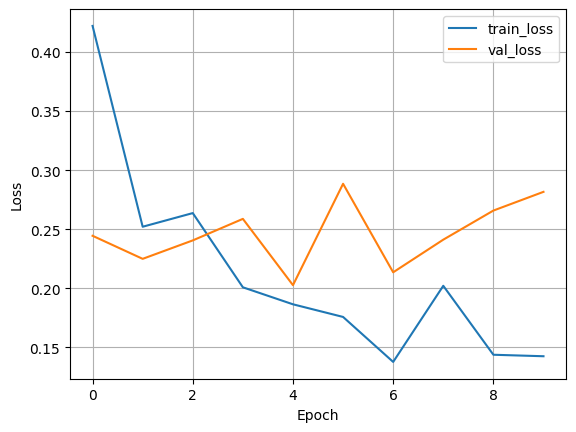

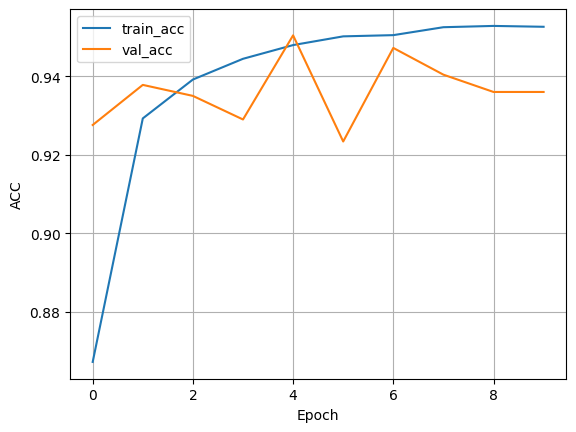

In [112]:
plot_csv_logs(trainer)